# Object Detection

Reset Kernel

In [ ]:
#import IPython
#app = IPython.Application.instance()
#app.kernel.do_shutdown(True)

In [ ]:
#%%capture
# Adapt adp-get to your distro
#!pip install -U jupyter
#!apt-get update && DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv unzip
#!pip install opencv-python torchvision torchaudio albumentations kaggle tdqm torchsummary torchmetrics seaborn
#!pip install --upgrade --quiet jupyter_client ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [3]:
#%%capture
#!mkdir -p ~/.kaggle
#!echo "{\"username\":\"vcguy2022\",\"key\":\"58a013ff978771be5b85417b3ee3917c\"}"  > /root/.kaggle/kaggle.json
#!kaggle datasets download andrewmvd/road-sign-detection
#!unzip road-sign-detection -d dataset/;

In [17]:
import cv2 as cv
import os
import random
import json
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
import xml.etree.ElementTree as ET
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import numpy as np
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Get train and validation datasets
images_directory = "dataset/images"
annotations_directory = "dataset/annotations"

train_split = 0.8

with open("train.txt") as train:
    train_images_filenames_total = train.read().splitlines()

    split_idx = int(train_split * len(train_images_filenames_total))
    train_images_filenames = train_images_filenames_total[:split_idx]
    val_images_filenames = train_images_filenames_total[split_idx:]


with open("test.txt") as test:
    test_images_filenames = test.read().splitlines()

# Filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
test_images_filenames = [i for i in test_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)
random.shuffle(val_images_filenames)
random.shuffle(test_images_filenames)

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

490 123 264


## Convert to YOLO annotations

In [19]:

# import shutil
# classes = {
#     "trafficlight": 0,
#     "stop": 1,
#     "speedlimit": 2,
#     "crosswalk": 3,
# }

# os.makedirs("dataset/labels", exist_ok=True)

# os.makedirs("dataset/images/train", exist_ok=True)
# os.makedirs("dataset/images/val", exist_ok=True)
# os.makedirs("dataset/images/test", exist_ok=True)
# os.makedirs("dataset/labels/train", exist_ok=True)
# os.makedirs("dataset/labels/val", exist_ok=True)
# os.makedirs("dataset/labels/test", exist_ok=True)


# for img in train_images_filenames:
#     shutil.copy(
#         f"dataset/images/{img}.png", f"dataset/images/train/{img}.png")

# for img in val_images_filenames:
#     shutil.copy(
#         f"dataset/images/{img}.png", f"dataset/images/val/{img}.png")

# for img in test_images_filenames:
#     shutil.copy(
#         f"dataset/images/{img}.png", f"dataset/images/test/{img}.png")


# for path in os.listdir(annotations_directory):
#     with open(os.path.join(annotations_directory, path), "r") as xml:
#         folder = ""
#         if path.strip(".xml") in train_images_filenames:
#             folder = "train"
#         elif path.strip(".xml") in val_images_filenames:
#             folder = "val"
#         else:
#             folder = "test"


#         with open(f"dataset/labels/{folder}/{path.replace('xml', 'txt')}", "w") as txt:
#             tree = ET.parse(xml)
#             root = tree.getroot()

#             size = root.find("size")
#             height = int(size.find("height").text)
#             width = int(size.find("width").text)

#             objects = root.findall("object")

#             lines = []
#             for object in objects:
#                 class_index = classes[object.find("name").text]

#                 xmin = int(object.find("bndbox/xmin").text)
#                 ymin = int(object.find("bndbox/ymin").text)
#                 xmax = int(object.find("bndbox/xmax").text)
#                 ymax = int(object.find("bndbox/ymax").text)

#                 # middle of bbox
#                 bbox_x = ((xmax + xmin) / 2) / width
#                 bbox_y = ((ymax + ymin) / 2) / height
#                 bbox_width = (xmax - xmin) / width
#                 bbox_height = (ymax - ymin) / height

#                 lines.append(
#                     f"{class_index} {bbox_x} {bbox_y} {bbox_width} {bbox_height}")

#             txt.write("\n".join(lines))



## Dataset

In [23]:
classes = {
    "trafficlight": 1,
    "stop": 2,
    "speedlimit": 3,
    "crosswalk": 4,
}


class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        
        
        
        
        image_filename = self.images_filenames[idx]
        image = cv.imread(os.path.join(
            self.images_directory, image_filename + ".png"))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        image = image / 255.

        boxes, labels = self._get_boxes_and_labels(image_filename)

        image_id = torch.tensor([idx])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transform is not None:
            transformed = self.transform(
                image=image, bboxes=target["boxes"], labels=target["labels"])
            image = transformed["image"]
            target["boxes"] = transformed["bboxes"]
            target["labels"] = transformed["labels"]

            if len(target["boxes"]) == 0:
                height, width, channels = image.shape
                target["boxes"] = torch.as_tensor(
                    [[0, 0, width, height]], dtype=torch.float32)
                target["labels"] = torch.as_tensor([0], dtype=torch.int64)

            target["boxes"] = torch.as_tensor(
                target["boxes"], dtype=torch.float32)
            target["labels"] = torch.as_tensor(
                target["labels"], dtype=torch.int64)

        return image.float(), target

    # https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    def _get_boxes_and_labels(self, filename):
        boxes = []
        labels = []
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            objects = root.findall("object")
            for object in objects:
                class_index = classes[object.find("name").text]

                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_index)

        return boxes, labels


In [24]:
num_classes = len(classes) + 1

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

batch_size = 32
num_workers = 0  # how many processes are used to load the data

train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.RandomSizedBBoxSafeCrop(224, 224),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2,
                           rotate_limit=30, p=0.5),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['labels'])
)

val_transform = A.Compose(
    [A.Resize(256, 256), A.RandomSizedBBoxSafeCrop(224, 224), ToTensorV2()],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['labels'])
)

test_transform = A.Compose(
    [A.Resize(256, 256), ToTensorV2()],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['labels'])
)

train = TrafficSignDataset(annotations_directory,
                           train_images_filenames, images_directory, train_transform)
val = TrafficSignDataset(annotations_directory,
                         val_images_filenames, images_directory, val_transform)
test = TrafficSignDataset(annotations_directory,
                          test_images_filenames, images_directory, test_transform)

train_dataloader = DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True, collate_fn=lambda batch: tuple(zip(*batch)))
val_dataloader = DataLoader(val, batch_size=batch_size,
                            shuffle=False, num_workers=num_workers, drop_last=False, collate_fn=lambda batch: tuple(zip(*batch)))
test_dataloader = DataLoader(
    test, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False, collate_fn=lambda batch: tuple(zip(*batch)))


Using cuda device


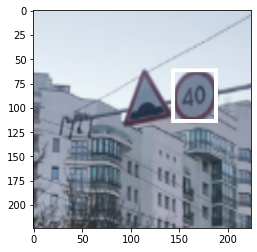

In [31]:
image, target = train[60]

img = draw_bounding_boxes(torch.as_tensor(image*255, dtype=torch.uint8), 
              boxes=target["boxes"], 
 #             labels=list(map(lambda x: classes[x-1], target["labels"])), 
              width=4
             )

# Display image
img = img.detach()
img = torchvision.transforms.functional.to_pil_image(img)

plt.imshow(img);

## Two-Stage

In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    pretrained=True)
model.backbone.requires_grad_(False)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device);

print(model)

# from torchmetrics import JaccardIndex
# metric = JaccardIndex(num_classes=num_classes)


In [ ]:
MODELS_DIR = "models"

class ModelTrainer:
    def __init__(self, *args):
        if len(args) == 5:
            model, model_name, optimizer, device = args
        elif len(args) == 2:
            ks = ["model", "name", "num_epochs", "optimizer"]
            model, model_name, num_epochs, optimizer = [
                args[0][k] for k in ks]
            device = args[1]

        self.model = model
        self.model_name = model_name
        self.curr_epoch = 0
        self.num_epochs = num_epochs  # Epochs that each training session will have
        self.scheduler = None
        self.optimizer = optimizer
        self.device = device
        self.metrics = {}

    def set_scheduler(self, scheduler, gamma):
        if scheduler != None:
            self.scheduler = scheduler(self.optimizer, gamma)

    def predict_data(self, data):
        # TODO change
        print("Predicting data")
        preds = []
        actuals = []
        with torch.set_grad_enabled(False):
            for _, (X, y) in enumerate(tqdm(data)):
                pred = self.model(X)
                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred)
                actuals.extend(y)
        return torch.stack(preds, dim=0), torch.stack(actuals, dim=0)

    def _epoch_iter(self, dataloader):

        num_batches = len(dataloader)
        self.model.train()  # put model in train mode

        total_loss = 0.0
        with torch.set_grad_enabled(True):
            for images, targets in tqdm(dataloader):
                images = list(image.to(self.device) for image in images)
                targets = [{k: v.to(self.device) for k, v in t.items()}
                           for t in targets]

                # Compute loss
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                # Backpropagation
                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += losses.item()

        return total_loss / num_batches

    def _eval(self, dataloader, metric):
        model.eval()

        with torch.set_grad_enabled(False):
            for images, targets in tqdm(dataloader):
                images = list(image.to(self.device) for image in images)

                outputs = self.model(images)
                outputs = [{k: v.to("cpu") for k, v in t.items()}
                           for t in outputs]

                # res = {target["image_id"].item(): output for target,
                #        output in zip(targets, outputs)}

                metric.update(outputs, targets)

        return metric.compute()
    
    def test(self, metric):
        return self._eval(test_dataloader, metric)

    def _save_model(self, t, file_name):
        import os
        os.makedirs(MODELS_DIR, exist_ok=True)

        model_path = os.path.join(
            MODELS_DIR, f'{self.model_name}_{ file_name }.pth')

        save_dict = {'model': self.model.state_dict(
        ), 'optimizer': self.optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_path)

        metrics_path = os.path.join(
            MODELS_DIR, f'{self.model_name}_metrics_history.json')
        with open(metrics_path, 'w') as f:
            f.write(json.dumps(self.metrics))

    def load_model(self, file_name):
        model_path = os.path.join(
            MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        metrics_path = os.path.join(
            MODELS_DIR, f'{self.model_name}_metrics_history.json')
        dic = torch.load(model_path)
        self.model.load_state_dict(dic['model'])
        self.model.eval()

        with open(metrics_path, 'r') as f:
            self.metrics = json.load(f)

        print(f"Loaded { self.model_name } obtained in epoch { dic['epoch'] }")

    def append_history(self, stage, train_data, val_data):
        self.metrics[stage] = {
            "train": {
                "loss": train_data
            },
            "val": {

            }
        }
        for k in val_data.keys():
            self.metrics[stage]["val"][k] = val_data[k].tolist()

    def reset_metrics(self):
        self.metrics = {}

    def train(self, train_dataloader, validation_dataloader, stage):
        # Stage => String identifier of the training iteration. Is used to identify between
        # the same model being trained at different contexts (ex. fine tunning)

        metric = MeanAveragePrecision(
            box_format="xyxy", iou_type="bboxes", class_metrics=True)

        best_val_meanap = np.inf
        print("Start training...")

        for _ in range(self.num_epochs):
            t = self.curr_epoch
            print(f"\nEpoch {t}")

            # Train
            train_loss = self._epoch_iter(train_dataloader)
            print(f"Train loss: {train_loss:.3f}")

            # Validation
            val_meanap = self._eval(validation_dataloader, metric)
            print(f'Mean Average Precision: {val_meanap["map"]}')

            # save training history for plotting purposes
            self.append_history(f'{stage}_{t}', (train_loss), (val_meanap))

            # Save model when validation loss improves
            if val_meanap["map"] < best_val_meanap:
                best_val_meanap = val_meanap["map"]
                self._save_model(f'{stage}_{t}', 'best_model')

            # Save latest model
            self._save_model(f'{stage}_{t}', 'latest_model')
            self.curr_epoch += 1

            # print(self.metrics)

        print("Finished")

    def freeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_head(self):
        self.model.roi_heads.requires_grad = True

    # Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    def visualize_model(self, test_dataloader, classes, num_images=6):
        self.model.eval()
        images_so_far = 0
        fig, axs = plt.subplots(ncols=num_images, squeeze=False, figsize=(50, 80))
        classes = list(classes.keys())

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_dataloader):
                images = list(image.to(self.device) for image in images)
                labels = [{k: v.to(self.device) for k, v in t.items()}
                           for t in labels]

                outputs = self.model(images)
                for img, output in zip(images, outputs):
                    img = draw_bounding_boxes(torch.as_tensor(img.cpu()*255, dtype=torch.uint8), 
                                              boxes=output['boxes'][output['scores'] > 0.5], 
                                              labels=list(map(lambda x: classes[x-1], output["labels"])), 
                                              width=4
                                             )
                    
                    # Display image
                    img = img.detach()
                    img = torchvision.transforms.functional.to_pil_image(img)
                    axs[0, images_so_far].imshow(np.asarray(img))
                    axs[0, images_so_far].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
                    images_so_far += 1
                    
                if images_so_far == num_images:
                    return


In [ ]:
def plotTrainingHistory(metrics, session):
    session_accs = filter(lambda x: x.startswith(session), metrics)
    train_loss, val_map = [], []
    classes_pre = {c:[] for c in classes}
    for t in session_accs:
        epoch_acc = metrics[t]
        train_loss.append(epoch_acc["train"]["loss"])
        val_map.append(epoch_acc["val"]["map"])
        for c in classes_pre:
            pre = epoch_acc["val"]["map_per_class"][classes[c] - 1]
            classes_pre[c].append(pre)

    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(train_loss, label='train')
    plt.legend(loc='best')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.title('Mean Average Precision')
    plt.plot(val_map, label='val')
    plt.legend(loc='best')
    plt.show()

    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(20)
    plt.subplot(4, 1, 2)
    plt.title('Per Class Mean Average Precision')
    for c in classes:  
        plt.plot(classes_pre[c], label=c)
    plt.legend(loc='best')
    plt.show()

In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

frcnn = {
    "model": model,
    "name": 'frcnn',
    "num_epochs": 10,
    "optimizer": optimizer
}


In [ ]:
frcnn_trainer = ModelTrainer(frcnn, device)
frcnn_trainer.scheduler = lr_scheduler
# Unfreeze all layers expect last
# frcnn_trainer.freeze_layers()
# frcnn_trainer.unfreeze_head()
model.backbone.requires_grad_(False)


def load_model(trainer):  # Returns True if success
    import os
    path = os.path.join(MODELS_DIR, trainer.model_name + '_best_model.pth')
    file_exists = os.path.exists(path)
    print(trainer.model_name + '_best_model.pth')
    if not file_exists:
        print("Saved model not found, training instead.")
        return False
    else:
        frcnn.load_model("best_model")
        return True


# Training can be skipped by loading the best model until now
load = False  # Change this to False to force to retrain
if load:
    need_train = (load_model(frcnn_trainer) == False)
if not load or need_train:
    frcnn_trainer.train(train_dataloader, val_dataloader, "frozen")


In [ ]:
frcnn_trainer.visualize_model(test_dataloader, classes)

In [ ]:
plotTrainingHistory(frcnn_trainer.metrics, "frozen")

## One-Stage

In [ ]:
# !git clone https://github.com/ultralytics/yolov5

# !pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [ ]:
# Might need to be run on linux/WSL
# !python3 yolov5/train.py --batch 10 --epochs 30 --data trafficsigns.yaml
# python yolov5/train.py --batch -1 --epochs 3 --data trafficsigns.yaml --workers 0

In [ ]:
# Detection
# !python3 yolov5/detect.py --weights yolov5/runs/train/exp22/weights/best.pt --img 640 --conf 0.25 --source dataset/images/train/road2.png